In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Define functions

In [6]:
def read_csv(file_name, metric_name):
    df = pd.read_csv(f'inputs/{file_name}_{metric_name}.csv')
    return df

def filter_by_technology(df, metric_name, technologies_of_interest):
    df = df[df['techs'].isin(technologies_of_interest)]
    aggregated_df = df.groupby(['spore', 'techs'])[f'{metric_name}'].sum().reset_index()
    return aggregated_df

def max_min_capacity_by_tech(aggregated_df, metric_name):
    max_capacity_by_tech = aggregated_df.groupby('techs')[f'{metric_name}'].max()
    min_capacity_by_tech = aggregated_df.groupby('techs')[f'{metric_name}'].min()
    return max_capacity_by_tech, min_capacity_by_tech

def normalize_capacity(aggregated_df, metric_name, max_capacity_by_tech, min_capacity_by_tech):
    aggregated_df[f'normalized_{metric_name}'] = aggregated_df.apply(
        lambda row: (row[f'{metric_name}'] - min_capacity_by_tech[row['techs']]) / (max_capacity_by_tech[row['techs']]- min_capacity_by_tech[row['techs']]), axis=1)
    return aggregated_df

def plot_initialization(technologies_of_interest):
    np.random.seed(0)  # For reproducibility
    colors = np.random.rand(len(technologies_of_interest), 3)  # Generate as many colors as there are technologies
    tech_color_dict = dict(zip(technologies_of_interest, colors))
    return tech_color_dict

def plot_distribution(aggregated_df, metric_name, tech_color_dict, file_name):
    plt.figure(figsize=(10, 6))
    # sns.violinplot(x='techs', y=metric_name, data=aggregated_df, palette=tech_color_dict, inner="quart")
    sns.boxplot(x='techs', y=metric_name, data=aggregated_df, palette=tech_color_dict)
    plt.xlabel('Technology')
    plt.ylabel(f'{metric_name}')
    plt.savefig(f'outputs/{metric_name}_distribution_{file_name}.png', dpi=300, format='png')
    plt.show()

def split_by_percentile_or_value(aggregated_df, tech, metric_name, value, is_percentile=True):
    if is_percentile:
        # Convert percentile to a proportion
        value = value / 100.0
        threshold = aggregated_df[aggregated_df['techs'] == tech][metric_name].quantile(value)
    else:
        threshold = value
    
    # Identify 'spore' values where 'nuclear' normalized_capacity is either above or below the 75th percentile
    above = aggregated_df[(aggregated_df['techs'] == tech) & (aggregated_df[metric_name] >= threshold)]['spore']
    below = aggregated_df[(aggregated_df['techs'] == tech) & (aggregated_df[metric_name] < threshold)]['spore']

    # Filter the DataFrame to only include rows from these 'spores' for both cases
    above_df = aggregated_df[aggregated_df['spore'].isin(above)]
    below_df = aggregated_df[aggregated_df['spore'].isin(below)]
    
    return above_df, below_df

def create_subplots(aggregated_df, tech, metric_name, percentile, above_df, below_df, tech_color_dict, file_name):
    # Create subplots

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.swarmplot(ax=axes[0], x='techs', y=f'{metric_name}', data=aggregated_df, palette=tech_color_dict)
    axes[0].set_title(f'{metric_name}')

    sns.swarmplot(ax=axes[1], x='techs', y=f'{metric_name}', data=above_df, palette=tech_color_dict)
    axes[1].set_title(f'{metric_name} > {percentile}th Percentile')

    sns.swarmplot(ax=axes[2], x='techs', y=f'{metric_name}', data=below_df, palette=tech_color_dict)
    axes[2].set_title(f'{metric_name} < {percentile}th Percentile')

    # Set common labels
    for ax in axes:
        ax.set_xlabel('Technology')
        ax.set_ylabel(f'{metric_name}')

    plt.tight_layout()
    plt.savefig(f'outputs/subplots_stripplot_{metric_name}_{tech}_{percentile}pct_{file_name}.png', dpi=300, format='png')
    plt.show()

    
def prepare_corr_matrix(df, metric_name, interested_techs):
    filtered_df = df[df['techs'].isin(interested_techs)]
    pivot_df = filtered_df.pivot(index='spore', columns='techs', values=f'{metric_name}')
    pivot_df_cleaned = pivot_df.dropna()
    return pivot_df_cleaned.corr()

def create_correlation_heat_maps(metric_name, percentile, corr_matrix_aggregated, corr_matrix_above, corr_matrix_below):

    fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 

    sns.heatmap(corr_matrix_aggregated, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axs[0])
    axs[0].set_title('Aggregated Data')

    sns.heatmap(corr_matrix_above, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axs[1])
    axs[1].set_title(f'Above {percentile}th Percentile Data')

    sns.heatmap(corr_matrix_below, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axs[2])
    axs[2].set_title(f'Below {percentile}th Percentile Data')

    plt.tight_layout()
    plt.savefig(f'outputs/subplots_{metric_name}_correlation_{file_name}.png', dpi=300, format='png')
    plt.show()



Define parameters

In [7]:
# Parameters
file_name = "slack-15"
metric_names = ['nameplate_capacity', 'flow_out_sum']
processed_metric_names = ['nameplate_capacity', 'flow_out_sum', 'normalized_nameplate_capacity', 'normalized_flow_out_sum']
active_name = processed_metric_names[3]
technologies_of_interest = ['nuclear', 'wind_offshore', 'wind_onshore', 'electrolysis', 'battery']




Data preparation: filtering and normalization

In [8]:

dfs = []
aggregated_dfs = []
for metric_name in metric_names:
    df = read_csv(file_name, metric_name)
    dfs.append(df)
    aggregated_df = filter_by_technology(df, metric_name, technologies_of_interest)
    max_capacity_by_tech, min_capacity_by_tech = max_min_capacity_by_tech(aggregated_df, metric_name)
    normalize_capacity(aggregated_df, metric_name, max_capacity_by_tech, min_capacity_by_tech)
    aggregated_dfs.append(aggregated_df)
    
aggregated_df = pd.concat(aggregated_dfs, axis=1)
aggregated_df = aggregated_df.loc[:, ~aggregated_df.columns.duplicated()]


Plot distribution

C:\Users\wangn\AppData\Local\Temp\ipykernel_6836\1184715763.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='techs', y=metric_name, data=aggregated_df, palette=tech_color_dict)


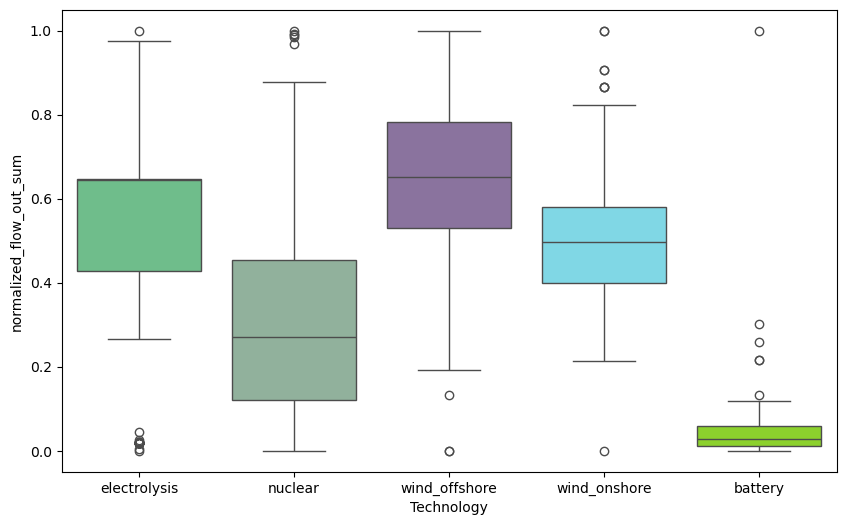

In [9]:
tech_color_dict = plot_initialization(technologies_of_interest)
plot_distribution(aggregated_df, active_name, tech_color_dict, file_name)


Plot subplots of stripplots

C:\Users\wangn\AppData\Local\Temp\ipykernel_6836\1184715763.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(ax=axes[0], x='techs', y=f'{metric_name}', data=aggregated_df, palette=tech_color_dict)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 23.2% of the points cannot

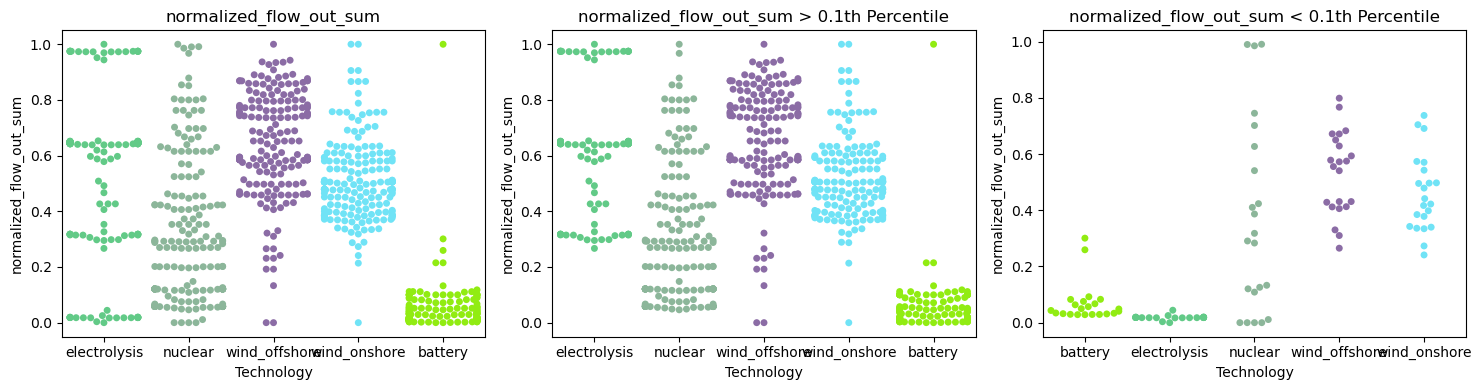

In [10]:
above_df, below_df = split_by_percentile_or_value(aggregated_df, 'electrolysis', active_name, 0.1, is_percentile=False)
create_subplots(aggregated_df, 'electrolysis', active_name, 0.1, above_df, below_df, tech_color_dict, file_name)


Plot heat maps for correlation analysis

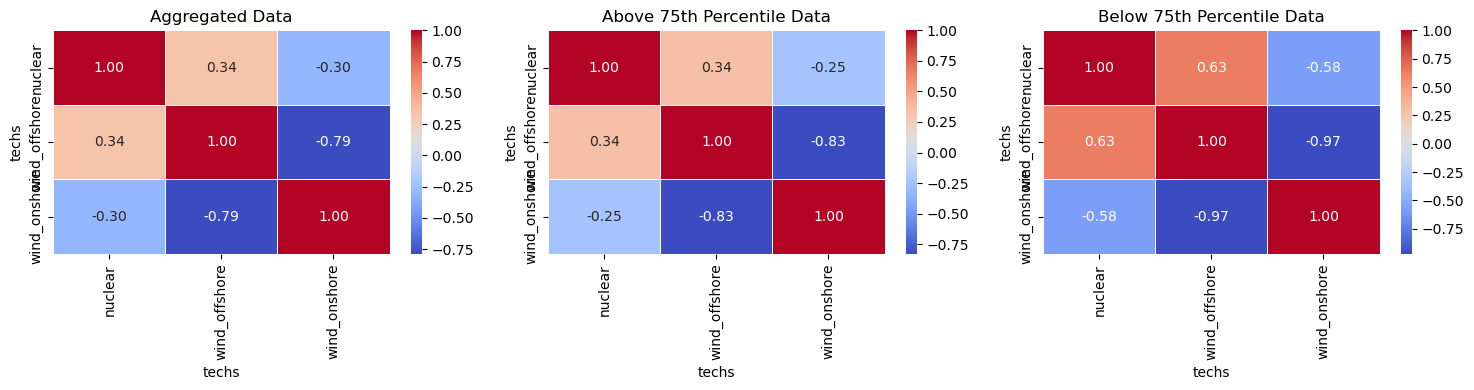

In [11]:

interested_techs_correlation = ['nuclear', 'wind_offshore', 'wind_onshore']
corr_matrix_aggregated = prepare_corr_matrix(aggregated_df, active_name, interested_techs_correlation)
corr_matrix_above = prepare_corr_matrix(above_df, active_name, interested_techs_correlation)
corr_matrix_below = prepare_corr_matrix(below_df, active_name, interested_techs_correlation)

create_correlation_heat_maps(active_name, 75, corr_matrix_aggregated, corr_matrix_above, corr_matrix_below)